In [2]:
import numpy as np
import pandas as pd 
import torchaudio
import os
import matplotlib.pyplot as plt
import librosa
# from music21 import *
from IPython.display import Audio
import numpy as np
from scipy.signal import lfilter
import IPython
import torchaudio.functional as F
import IPython.display as ipd
import torchaudio.transforms as T
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import models
file_, sr = librosa.load("/kaggle/input/audiogen/ta_in_male/tag_00023_00002135809.wav")

In [3]:
from tqdm import tqdm
import glob

data=[]
length=4 # 4 seconds

for path in tqdm(glob.glob("/kaggle/input/audiogen/ta_in_female/*.wav")):
    file, _ = librosa.core.load(path, sr=sr)
    if len(file) > sr*length:
        data.append(file[:sr*length])
data = np.array(data)

100%|██████████| 2335/2335 [09:52<00:00,  3.94it/s]


In [4]:
def normalization(X):
    mean = X.mean(keepdims=True)
    std = X.std(keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

def rescale(X, rangeMin=-1, rangeMax=+1):
    maxi = X.max()
    mini = X.min()
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

x_train = normalization(data)
x_train = rescale(x_train)

Data Normalized...
Data Rescaled...


In [6]:
dims_number = 200
def create_generator():
    
    generator = Sequential()
    generator.add(Dense(units = 1024, input_dim = dims_number))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 2048))
    generator.add(ReLU())
    
    generator.add(Dense(units = 2048))
    generator.add(ReLU())
    
    generator.add(Dense(units = x_train.shape[1]))
    
    generator.compile(loss ="binary_crossentropy",
                     optimizer = Adam(lr = 0.000001))
    
    return generator

g = create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              205824    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
re_lu_5 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
re_lu_6 (ReLU)               (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)             

In [7]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 2048,input_dim = x_train.shape[1])) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 1024)) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 512)) 
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units = 1, activation = "sigmoid"))
    
    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(lr = 0.0001))
    return discriminator

d = create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2048)              180635648 
_________________________________________________________________
re_lu_8 (ReLU)               (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
re_lu_9 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)              

In [8]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(dims_number,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 88200)             188272776 
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 183259137 
Total params: 371,531,913
Trainable params: 188,272,776
Non-trainable params: 183,259,137
_________________________________________________________________


2023-02-12 02:24:16.811667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


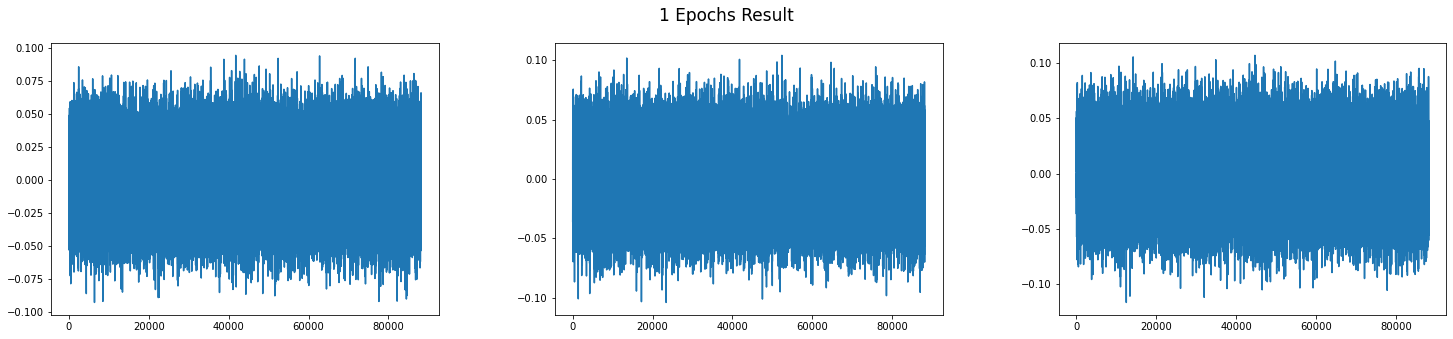

In [9]:
import numpy as np
from scipy.signal import lfilter
from scipy import signal
def high_pass_filter(data, cutoff, fs):
    # Define the filter coefficients using the cutoff frequency
    nyquist = 0.5 * fs
    cutoff = cutoff / nyquist
    b, a = signal.butter(5, cutoff, 'high')

    # Apply the filter to the data
    filtered_data = lfilter(b, a, data)

    return filtered_data

def low_pass_filter(data, cutoff, fs):

    nyquist = 0.5 * fs
    cutoff = cutoff / nyquist
    b, a = signal.butter(5, cutoff, 'high')

    # Apply the filter to the data
    filtered_data = lfilter(b, a, data)

    return filtered_data

fs = sr 


def show_gen_samples(epochs, samples = 3):
    samplePlot = []
    fig        = plt.figure(figsize = (1, samples))
    noise      = np.random.normal(0, 1, (samples,dims_number))
    audios     = g.predict(noise)     
    cutoff = 500

    for i, audio in enumerate(audios):
        IPython.display.display(ipd.Audio(data = audio, rate = sr))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '-', )
    plt.gcf().set_size_inches(25, 5)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("{} Epochs Result".format(epochs), fontsize = 17)
    plt.show()
    
show_gen_samples(1)

In [11]:
import time
import IPython
import IPython.display as ipd

D_loss = []
G_loss = []
epochs = 150 
batch_size = 32
current_time = time.time()

for e in range(epochs):
    start_time = time.time()
    for _ in range(batch_size):
        # I reccomend you to look "Training Diagram" (at the top) 
        noise = np.random.normal(0,1, [batch_size,dims_number])
        
        generated_audio = g.predict(noise)
       
        audio_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)] #get samples from real data
        
        x = np.concatenate([audio_batch, generated_audio])
        
        y_dis = np.zeros(batch_size*2) 
        y_dis[:batch_size] = 1 
        
        d.trainable = True
        d_loss = d.train_on_batch(x,y_dis) 
        
        noise = np.random.normal(0,1,[batch_size,dims_number])
        
        y_gen = np.ones(batch_size) 
        
        d.trainable = False
        
        g_loss = gan.train_on_batch(noise, y_gen) #train_on_batch
        
        D_loss.append(d_loss)
        G_loss.append(g_loss)
        
    if (e%2 == 0) or (e == epochs-1) :
        print("epochs: ",e)
    if e == epochs-1:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        print("Training Complete.")
    
    # printing results
    if e%10 == 0:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        

epochs:  0
Time since start: 0.0
epochs:  2
epochs:  4
epochs:  6
epochs:  8
epochs:  10
Time since start: 58.0
epochs:  12
epochs:  14
epochs:  16
epochs:  18
epochs:  20
Time since start: 111.0
epochs:  22
epochs:  24
epochs:  26
epochs:  28
epochs:  30
Time since start: 164.0


KeyboardInterrupt: 

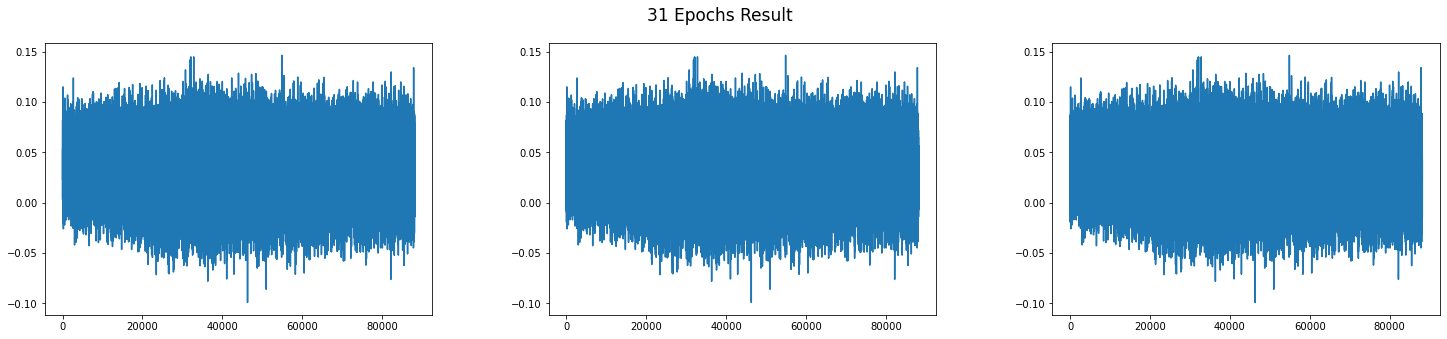

In [12]:
show_gen_samples(e)

In [14]:
# index = 0
# D_loss2 = []
# G_loss2 = []

# for i in range(1,epochs+1):
#     D_loss2.append(D_loss[index])
#     G_loss2.append(G_loss[index])
#     index += batch_size

# fig, axs = plt.subplots(2, 1, figsize = (12,10))

# axs[0].plot(D_loss2, label = "Discriminator Loss")
# axs[1].plot(G_loss2, label = "Generator Loss", color = "orange")

# axs[0].set_xlabel("Epochs")
# axs[1].set_xlabel("Epochs")

# axs[0].set_ylabel("Loss")
# axs[1].set_ylabel("Loss")

# axs[0].set_title("Discriminator Loss")
# axs[1].set_title("Generator Loss")
# plt.show()